# 평가

머신러닝은 데이터 가공/변환, 모델 학습/예측, 그리고 평가(Evaluation)의 프로세스로 구성된다.  

성능 평가 지표(Evaluation Metric)는 일반적으로 모델이 분류나 회귀냐에 다라 여러 종류로 나뉜다.
* 회귀: 실제값과 예측값의 오차 평균값에 기반  

* 분류: 실제 결과 데이터와 예측 결과 데이터가 얼마나 정확하고 얼마나 오류가 적게 발생하는가에 기반, 이런 정확도만 가지고 판단하는 것은 오류가 발생할 수 있다. 특히 이진 분류의 경우 정확도보다는 다른 성능 지표가 더 중요시된다.

분류의 성능 평가 지표
* 정확도(Accuracy)
* 오차행렬(Confusion Matrix)
* 정밀도(Precision)
* 재현율(Recall)
* F1 스코어
* ROC AUC

분류는 결정 클래스 값 종류의 유형에 따라 긍정/부정과 같은 2개의 결괏값만을 가지는 이진 분류와 여러 개의 결정 클래스 값을 가지는 멀티 분류로 나뉠 수 있습니다.

## 1. 정확도(Accuracy)

실제 데이터에서 예측 데이터가 얼마나 같은지를 판단하는 지표  

정확도 = 예측결과가 동일한 데이터 건수 / 전체 예측 데이터 건수  

타이타닉의 예시를 봤을때 단지 성별 조건 하나만을 가지고 결정해도 80%의 정확도가 나올 수 있기에 이 지표에 의구심이 들 수 있다.

타이타닉의 성별에 따라 생존자를 예측하는 단순한 분류기를 만들어보자

In [1]:
from sklearn.base import BaseEstimator

class MyDummyClassifier(BaseEstimator):
    #fit() 메서드는 아무것도 학습하지 않음.
    
    def fit(self,X, y=None):
        pass
    def predict(self,X):
        pred = np.zeros((X.shape[0],1))
        for i in range(X.shape[0]):
            if X['Sex'].iloc[i] ==1:
                pred[i] = 0
            else :
                pred[i] = 1
                
        return pred

In [2]:
## 생성된 MyDummyClassifier를 이용해 타이타닉 생존자 예측 수행

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

## Null 처리 함수
def fillna(df):
    df['Age'].fillna(df['Age'].mean(), inplace=True)
    df['Cabin'].fillna('N', inplace=True)
    df['Embarked'].fillna('N', inplace=True)
    df['Fare'].fillna(0, inplace=True)
    return df

## 머신러닝에 불필요한 피처 제거
def drop_features(df):
    df.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)
    return df

## Label Encoding 수행
def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin', 'Sex', 'Embarked']
    for feature in features:
        le = LabelEncoder()
        le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df

## 앞에서 실행한 Data Preprocessing 함수 호출
def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df

In [3]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


#원본 데이터 재로딩, 데이터 가공, 학습 데이터/테스트 데이터 분할.
titanic_df = pd.read_csv('./titanic_train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis=1)
X_titanic_df = transform_features(X_titanic_df)
X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size=0.2, random_state=0)
myclf = MyDummyClassifier()
myclf.fit(X_train, y_train)

mypredictions = myclf.predict(X_test)
print('Dummy Classifier의 정확도는: {0:.4f}'.format(accuracy_score(y_test,mypredictions)))

Dummy Classifier의 정확도는: 0.7877


단순한 알고리즘으로 예측해도 데이터의 구성에 따라 정확도 결과는 높은 수치가 나온다.  
특히 불균형한(imbalanced)레이블 값 분포에서 ML모델의 성능을 판단할 경우, 적합한 평가 지표가 아니다.

MNIST데이터를 활용해 불균형 데이터의 정확도 지표 적용시 어떤 문제가 발생하는지 알아보자  
원래는 0~9숫자를 10개로 구분하는 멀티 레이블 분류인데, 이번만 7과 나머지의 이진 분류 레이블로 바꿔보자  


In [4]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

class MyFakeClassifier(BaseEstimator):
    def fit(self,X,y):
        pass
    
    #입력값으로 들어오는 x데이터 세트의 크기만큼 모두 0값으로 만들어서 반환
    def predict(self, X):
        return np.zeros((len(X),1), dtype=bool)
    
    
#사이킷런의 내장 데이터 세트인 load_digits()을 활용해 MNIST데이터 로딩 
digits = load_digits()

#번호가 7이면 True, 이를 astype(int)로 1로 반환, 7번이 아니면 False이고 0으로 변환
y = (digits.target == 7).astype(int)
X_train, X_test, y_train, y_test = train_test_split(digits.data, y, random_state=11)

In [5]:
#불균형한 레이블 데이터 분포도 확인
print('레이블 테스트 세트 크기:', y_test.shape)
print('테스트 세트 레이블 0과 1의 분포도')
print(pd.Series(y_test).value_counts())

#Dummy Classifier로 학습, 예측, 정확도 평가
fakeclf = MyFakeClassifier()
fakeclf.fit(X_train, y_train)
fakepred = fakeclf.predict(X_test)
print('모든 예측을 0으로 하여도 정확도는: {:.3f}'.format(accuracy_score(y_test,fakepred)))

레이블 테스트 세트 크기: (450,)
테스트 세트 레이블 0과 1의 분포도
0    405
1     45
dtype: int64
모든 예측을 0으로 하여도 정확도는: 0.900


단순히 0의 값을 반환함에도 450개의 테스트 데이터 세트에 수행한 예측 정확도는 90%이다.  
정확도가 가지는 분류 평가 지표로서의 한계를 극복하기 위해 여러가지 분류지표와 함께 적용하여 모델 성능을 평가해야 한다.

## 2. 오차 행렬

이진 분류에서 성능 지표로 잘 활용되는 오차행렬(confusion matrix, 혼동행렬)은 학습된 분류 모델이 예측을 수행하면서 얼마나 헷갈리고(confused) 있는지도 함께 보여주는 지표다.  
즉, 이진 분류의 예측 오류가 얼마인지와 더불어 어떠한 유형의 예측 오류가 발생하고 있는지를 함께 나타내는 지표이다.

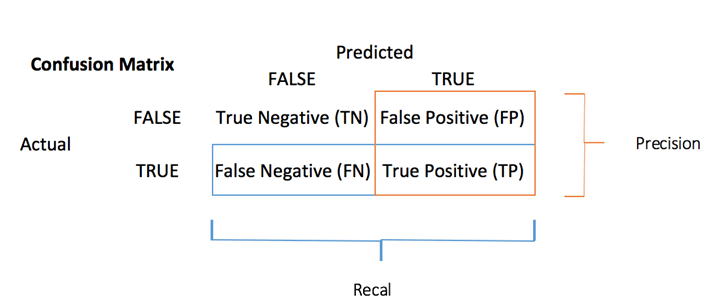

오차 행렬은 실제 레이블 클래스 값과, 예측 레이블 클래스 값이 어떠한 유형을 가지고 매핑되는지를 나타낸다. 4분면의 왼쪽, 오른쪽을 예측된 클래스 값 기준으로 Negative와 Positive로 분류하면 예측 클래스와 실제 클래스의 값 유형에 따라 결정되는 TN, EP, FN, TP 형태로 오차 행렬의 4분면을 채울 수 있습니다. TN, FP, FN, TP값을 다양하게 결합해 분류 모델 예측 성능의 오류 모습을 알 수 있다.  

 예측 클래스, 실제 클래스의 Positive 결정 값(1)과 Negative 결정 값(0)의 결합에 따라 결정된다. 예를 들어 TN은 True Negative의 의미이며 앞 True 예측 클래스의 값과 실제 클래스 값이 같다는 의미이고 뒤의 Negative는 예측값이 Negative값이라는 의미이다. 
즉, 예측을 Negative값으로 0으로 했는데, 실제 값도 Negative 값 0이라는 의미이다.  
앞문자 True/False는 예측값과 실제값이 '같은가/틀린가'를 의미한다.  
뒤문자 'Negative/Positive'는 예측 결과 값이 부정(0)/긍정(1)을 의미한다.


* TN은 예측값을 Negative 값 0으로 예측했고 실제 값 역시 Negative 값 0
* FP는 예측값을 Positive 값 1로 예측했는데 실제 값은 Negative 값 0
* FN은 예측값을 Negative 값 0으로 예측했는데 실제 값은 Positive 값 1
* TP는 예측값을 Positive 값 1로 예측했는데 실제 값 역시 Positive 값1

In [6]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test,fakepred)

array([[405,   0],
       [ 45,   0]], dtype=int64)

출력 형태는 ndarray이다.  
위의 값은 classifier성능의 여러 면모를 판단할 수 있는 기반 정보를 제공한다.  
이를 조합해 정확도(Accuracy), 정밀도(Precision), 재현율(Recall)값을 알 수 있다.

정확도는 오차 행렬상에서 다음과 같이 재정의된다.
* 정확도 = 예측 결과와 실제 값이 동일한 건수/전체 데이터 수 = (TN + TP) / (TN + FP + FN + TP)

뷸균형한 레이블 클래스에서는 매우적은 수의 결과값에 Positive 1값을 부여하고, 그렇지 않은 경우는 Negative 0 값을 부여하는 경우가 많다.  
불균형 이진 분류 데이터 셋에서 Positive 데이터 건수가 매우 작기 때문에 데이터에 기반한 ML알고리즘은 Positive 보다는 Negative로 예측 정확도가 높아지는 경향이 발생한다.  

예를 들어, 10000건의 데이터에서 9900건이 Negative이고, 100건이 Positive라면 Negative로 예측하는 경향이 더 강해서 TN은 매우 커지고, TP는 매우 작아지게 됩니다.  
또 Negative로 예측할때 정확도가 높기 때문에 FN이 매우 작고, Positive로 예측하는 경우가 작기에 FP도 매우 작아진다.  
결과적으로 Negative에 대한 예측 정확도만으로도 분류의 정확도가 매우 높게 나타나는 오류를 일으키게 된다.

## 3. 정밀도와 재현율

정밀도와 재현율은 Positive 데이터세트의 예측 성능에 좀 더 초점을 맞춘 평가 지표이다.
앞서 만든 MyFakeClassifier는 Positive로 예측한 TP값이 하나도 없기 때문에 정밀도와 재현율 값이 모두 0이었다.

* 정밀도 = TP/(FP + TP)
* 재현율 = TP/ (FN + TP)

정밀도는 예측을 Positive로 한 대상 중에 예측과 실제 값이 Positive로 일치한 데이터의 비율이다.  
분모인 FP+TP는 예측을 Positive로 한 모든 데이터 건수이며, 공식의 분자인 TP는 예측과 실제 값이 Positive로 일치한 데이터 건수이다.  
양성 예측도라고도 불린다.  

-> 즉, 분모는 실제 일어나지 않았는데 긍정으로 예측한 것 + 실제 일어났는데 긍정으로 예측한 것이다. 분자는 그 중 실제일어났고, 긍정으로 예측한 것을 갖는다. 이는 모델이 긍정으로 예측한 것 중에서 실제 얼마나 일어났는지를 확률로 나타낸 것으로 '정밀도'라는 단어를 이해할 수 있다.

재현율은 실제 값이 Positive한 대상 중에 예측과 실제 값이 Positive로 일치한 데이터의 비율을 뜻한다.  
공식의 분모인 FN + TP는 실제 값이 Positive인 모든 데이터 건수이며 공식의 분자인 TP는 예측과 실제값이 Positive로 일치한 데이터 건수이다.
민감도(Sensitivity)또는 TRP(True Positive Rate)라고도 불린다.

-> 즉, 분모는 실제 일어났는데 부정으로 예측한거 + 실제 일어났는데 긍정으로 예측한거이고 분자는 그 중 실제 일어났는데 긍정으로 예측한거를 나타낸다. 이 뜻은 실제에 비해 얼마나 모델이 '재현'을 잘 했느냐의 확률로 생각할 수도 있을 거 같다.

재현율이 중요 지표인 경우는 실제 Positive 양성 데이터를 Negative로 잘못 판단하게 되면 업무상 큰 영향이 발생하는 경우이다. 예를 들어 암 판단 모델은 Positive 양성이 아닌 Negative 음성을 판단했을 경우 오류의 대가가 생명을 앗아갈 정도로 심각하지 때문이다. 실제 Negative인 건강한 환자를 암 환자인 Positive로 예측한 경우 다시 한번 재검사 하는 수준의 비용만 발생한다.  
보험 사기, 금융 사기 적발 모델도 재현율이 중요하다. 실제 사기인 Positive 건을 Negative로 잘못 판단하게 되면 회사에 미치는 손해가 클 것이다. 반면에 정상 금융거래인 Negative를 금융 사기인 Positive로 잘못 판단하더라도 다시 한번 금융 사기인지 재확인하는 절차를 가동하면 된다.  
보통 재현율이 정밀도보다 상대적으로 중요한 업무가 많다.  

정밀도가 더 중요한 지표인 경우는 스팸메일 여부가 있다. 실제 Positive인 스팸 메일을 Negative로 일반메일로 분류해도 불편한 수준이지만 실제 Negative 일반메일을 Positive인 스팸으로 처리하면 업무에 차질이 생긴다. 

* 재현율이 상대적으로 더 중요한 지표인 경우는 실제 Positive 양성인 데이터 예측을 Negative로 잘못 판단하게 되면 업무상 큰 영향이 발생하는 경우
* 정밀도가 상대적으로 더 중요한 지표인 경우는 실제 Negative 음성인 데이터 예측을 Positive 양성으로 잘못 판단하게 되면 업무상 영향이 발생하는 경우

둘다 TP를 높이는데 동일하게 초점을 맞추지만, 재현율을 FN(실제 Positive, 예측 Negative)를 낮추는 데, 정밀도는 FP를 낮추는데 초점을 맞춘다. 재현율과 정밀도는 서로 보완적인 지표로 분류의 성능을 평가하는데 적용된다. 둘다 높은 경우 바람직하지만, 한 지표만 높은 것은 바람직하지 못하다.

In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

def get_clf_eval(y_test,pred):
    confusion = confusion_matrix(y_test,pred)
    accuracy = accuracy_score(y_test,pred)
    precision = precision_score(y_test,pred)
    recall = recall_score(y_test,pred)
    print('오차 행렬')
    print('confusion')
    print('정확도: {0:4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}'.format(accuracy, precision,recall))

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

titanic_df = pd.read_csv('titanic_train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived',axis=1)
X_titanic_df = transform_features(X_titanic_df)

X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size=0.20, random_state=11)

lr_clf = LogisticRegression(solver='liblinear') #로지스틱 회귀의 최적화 알고리즘 유형 지정, 보통 작은 데이터 세트의 이진 분류인 경우 linlinear가 약간 성능이 좋다.

lr_clf.fit(X_train,y_train)

pred = lr_clf.predict(X_test)
get_clf_eval(y_test,pred)

오차 행렬
confusion
정확도: 0.865922, 정밀도: 0.8246, 재현율: 0.7705


### 정밀도/재현율 트레이드오프

업무 특성상 정밀도 또는 재현율이 강조돼야할 경우 분류의 특정 임곗값을 조정해 정밀도 또는 재현율의 수치를 높일 수 있습니다.
정밀도와 재현율을 상호 보완적 지표이기 때문에 어느 한쪽을 강제로 높이면 다른 하나의 수치를 떨어지기 쉽습니다. 이를 정밀도/재현율의 Trads-off라고 합니다.

사이킷런의 분류 알고리즘은 예측 데이터가 특정 레이블에 속하는지를 계산하기 위해 먼저 개별 레이블별로 결정 확률을 구한다.
그리고 예측 확률이 큰 레이블 값으로 예측하게 된다.

predict_proba()는 개별 데이터별 예측 확률을 반환한다.
학습이 완료된 사이킷런 Classifier객체에서 호출이 가능하다.  
predict() 메서드와 유사하지만 단지 반환 결과가 예측결과 클래스값이 아닌 예측 확률 결과이다.

In [9]:
# 타이타닉  생존자 데이터에서 predict() 결과 값과 predict_proba() 결과 값을 비교
pred_proba = lr_clf.predict_proba(X_test)
pred = lr_clf.predict(X_test)

print('pred_proba의 shape: {0}'.format(pred_proba.shape))
print('pred_proba의 array에서 앞 3개만 샘플로 추출 :\n', pred_proba[:3])

#예측확률 array와 예측 결과값 array를 병합하여 예측확률과 결괏값을 한 번에 확인
pred_proba_result = np.concatenate([pred_proba, pred.reshape(-1,1)], axis=1)
print('두 개의 class 중 더 큰 확률을 클래스 값으로 예측\n', pred_proba_result[:3])

pred_proba의 shape: (179, 2)
pred_proba의 array에서 앞 3개만 샘플로 추출 :
 [[0.44935225 0.55064775]
 [0.86335511 0.13664489]
 [0.86429643 0.13570357]]
두 개의 class 중 더 큰 확률을 클래스 값으로 예측
 [[0.44935225 0.55064775 1.        ]
 [0.86335511 0.13664489 0.        ]
 [0.86429643 0.13570357 0.        ]]


사실 predict메서드는 prdict_proba()메서드에 기반해 생성된 API다.

In [10]:
from sklearn.preprocessing import Binarizer

# 예시
X = [[-1, -1, 2],
        [2, 0, 0], 
        [0, 1.1, 1.2]]

# X의 개별원소들이 threshold보다 크면 1, 작거나 같으면 0을 반환
binarizer = Binarizer(threshold=1.1)
print(binarizer.fit_transform(X))

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [11]:
# Binarizer의 threshold 값을 0.5로 설정
custom_threshold = 0.5

# predict_proba() 결과 값의 두 번째 컬럼, 즉 Positive 클래스의 컬럼 하나만 추출하여 Binarizer를 적용
pred_proba_1 = pred_proba[:,1].reshape(-1,1)

binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차 행렬
confusion
정확도: 0.865922, 정밀도: 0.8246, 재현율: 0.7705


In [12]:
# Binarizer의 threshold 값을 0.4로 설정
custom_threshold = 0.4

# predict_proba() 결과 값의 두 번째 컬럼, 즉 Positive 클래스의 컬럼 하나만 추출하여 Binarizer를 적용
pred_proba_1 = pred_proba[:,1].reshape(-1,1)

binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차 행렬
confusion
정확도: 0.821229, 정밀도: 0.7042, 재현율: 0.8197


임곗값을 낮추니 재현율 값이 올라가고 정밀도가 떨어진다, 분류 결정 임곗값은 Positive예측값을 결정하는 확률의 기준이 된다. 확률이 0.5가 아닌 0.4부터 Positive로 예측을 더 너그럽게 하기 때문에 임곗값 값을 낮출수록 True값이 많아지게 된다. 

In [13]:
# 임계값
thresholds = [0.4, 0.45, 0.5, 0.55, 0.6]

# 평가지표를 조사하기 위한 새로운 함수 생성
def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
    #thresholds list 객체 내의 값을 iteration 하면서 평가 수행
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)
        print('\n임계값: ', custom_threshold)
        get_clf_eval(y_test, custom_predict)

get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1, 1), thresholds)


임계값:  0.4
오차 행렬
confusion
정확도: 0.821229, 정밀도: 0.7042, 재현율: 0.8197

임계값:  0.45
오차 행렬
confusion
정확도: 0.854749, 정밀도: 0.7869, 재현율: 0.7869

임계값:  0.5
오차 행렬
confusion
정확도: 0.865922, 정밀도: 0.8246, 재현율: 0.7705

임계값:  0.55
오차 행렬
confusion
정확도: 0.871508, 정밀도: 0.8654, 재현율: 0.7377

임계값:  0.6
오차 행렬
confusion
정확도: 0.877095, 정밀도: 0.8980, 재현율: 0.7213


In [14]:
from sklearn.metrics import precision_recall_curve

# 레이블 값이 1일 떄의 예측확률을 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[ : , 1]

# 실제값 데이터 세트와 레이블 값이 1일 때 예측확률을 precision_recall_curve의 인자로 반환
precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_class1)
print('반환된 분류 결정 임계값 배열의 shape: ', thresholds.shape)

# 반환된 임계값 배열 로우가 147건 이므로 샘플로 10건만 추출하되, 임계값을 15 Step으로 추출
thr_index = np.arange(0, thresholds.shape[0], 15)
print('샘플 추출을 위한 임계값 배열의 index 10개: ', thr_index)
print('샘플용 10개의 임계값: ', np.round(thresholds[thr_index], 2))

# 15 step 단위로 추출된 임계값에 따른 정밀도와 재현율 값
print('샘플 임계값별 정밀도 : ', np.round(precisions[thr_index], 3))
print('샘플 임계값별 재현율 : ', np.round(recalls[thr_index], 3))

반환된 분류 결정 임계값 배열의 shape:  (165,)
샘플 추출을 위한 임계값 배열의 index 10개:  [  0  15  30  45  60  75  90 105 120 135 150]
샘플용 10개의 임계값:  [0.02 0.11 0.13 0.14 0.16 0.24 0.32 0.45 0.62 0.73 0.87]
샘플 임계값별 정밀도 :  [0.341 0.372 0.401 0.44  0.505 0.598 0.688 0.774 0.915 0.968 0.938]
샘플 임계값별 재현율 :  [1.    1.    0.967 0.902 0.902 0.902 0.869 0.787 0.705 0.492 0.246]


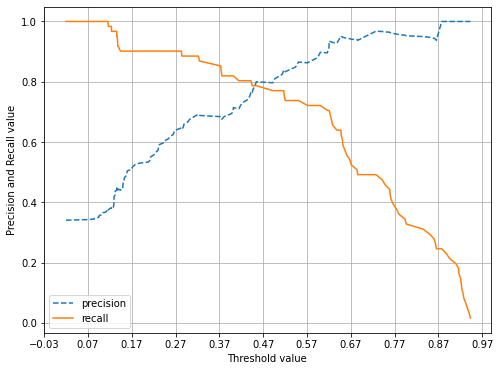

In [15]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def precision_recall_curve_plot(y_test, pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    # x축을 threshold 값, y축을 정밀도, 재현율로 그리기
    plt.figure(figsize=(8,6))
    thresholds_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0: thresholds_boundary], linestyle= '--', label='precision')
    plt.plot(thresholds, recalls[0: thresholds_boundary], label='recall')
    
    # threshold의 값 X축의 scale을 0.1 단위로 변경
    stard, end = plt.xlim()
    plt.xticks(np.round(np.arange(stard, end, 0.1), 2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value')
    plt.ylabel('Precision and Recall value')
    plt.legend()
    plt.grid()
    plt.show()

precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:,1])

### 정밀와 재현율의 맹점

임계값의 변경은 두 개의 수치를 상호 보완할 수 있는 수준에서 이뤄져야 한다.

### 정밀도가 100%가 되는 방법

확실한 기준이 되는 경우만 Positive로 예측하고, 모두 Negative로 예측한다. 기준을 명확하게 잡으면 된다.
정밀도 전체에서 확실한 Positive 징후만 예측하면 나머지 Negative여도 정밀도는 100%가 된다.

앞에서 말했듯이 Negative를 Positive로 잘못 예측했을 때 발생할 문제가 크다면 정밀도를 높이는게 유리할 것이다.

### 재현율이 100%가 되는 방법

모든 환자를 Positive로 예측한다, 실제 30%가 양성이라도 TN수치에 포함 안되고 FN은 0이므로 100%가 된다.

Positive를 Negative로 예측했을때 문제가 크다면 재현율이 높이는게 유리할 것이다.


하지만 좋은 알고리즘이라면 정밀도/재현율 중 하나만 강조해서는 안된다.
정확도/재현율의 수치가 적절하게 조합되 분류의 종합적인 성능 평가에 사용될 수 있는 평가 지표가 필요하다.

## 4. F1 스코어

정밀도와 재현율을 결합한 지표, 한쪽으로 치우치지 않은 수치를 나타낼 때 상대적으로 높은 값을 가진다.

In [16]:
from sklearn.metrics import f1_score
f1 = f1_score(y_test, pred)
print('F1 스코어 : {:.4f}'.format(f1))

F1 스코어 : 0.7966


In [17]:
def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    # F1 스코어 추가
    f1 = f1_score(y_test, pred)
    print('오차행렬')
    print(confusion)
    # F1 score print 추가
    print('\n정확도: {:.4f}\n정밀도: {:.4f}\n재현율: {:.4f}\nF1: {:.4f}'.format(accuracy, precision, recall, f1))
    
thresholds = [0.4, 0.45, 0.5, 0.55, 0.6]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1, 1), thresholds)


임계값:  0.4
오차행렬
[[97 21]
 [11 50]]

정확도: 0.8212
정밀도: 0.7042
재현율: 0.8197
F1: 0.7576

임계값:  0.45
오차행렬
[[105  13]
 [ 13  48]]

정확도: 0.8547
정밀도: 0.7869
재현율: 0.7869
F1: 0.7869

임계값:  0.5
오차행렬
[[108  10]
 [ 14  47]]

정확도: 0.8659
정밀도: 0.8246
재현율: 0.7705
F1: 0.7966

임계값:  0.55
오차행렬
[[111   7]
 [ 16  45]]

정확도: 0.8715
정밀도: 0.8654
재현율: 0.7377
F1: 0.7965

임계값:  0.6
오차행렬
[[113   5]
 [ 17  44]]

정확도: 0.8771
정밀도: 0.8980
재현율: 0.7213
F1: 0.8000


## 5. ROC 곡선과 AUC

이진 분류의 예측 성능 측정에서 중요하게 사용되는 지표이다.  
ROC 곡선(Receiver Operation Curve)는 우리말로 수신자 판단 곡선으로 불린다. 
FPR(False Positive Rate)가 변할 때 TPR(True Positive Rate)가 어떻게 변하는지를 나타내는 곡선이다.

TPR은 True Pocitive Rate의 약자로 재현율을 나타낸다. 민감도로도 불린다.  
대응하는 지표인 TNR(True Negative Rate)는 특이성이라고 불린다.

* 민감도(TPR)는 실제값 Positive가 정확히 예측되어야 하는 수준을 나타낸다.
* 특이성(TNR)은 실제값 Negative가 정확히 예측되어야 하는 수준을 나타낸다.  

TNR인 특이성은 TNR = TN / (FP+TN)  
ROC곡선의 X축인 FPR은 FPR = FP/ (FP+TN) = 1 - TNR = 1-특이성 or TNR  


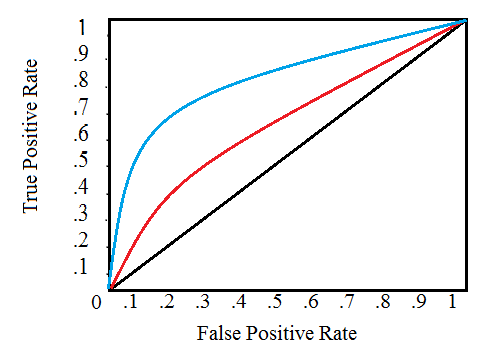
가운데 직선은 곡선의 최저값이다.

대각선 직선은 무작위 랜덤수준의 이진 분류 ROC직선이다.  
ROC 곡선이 가운데 직선에 가까울수록 성능이 떨어진다.
멀어질수록 성능이 뛰어나다.  

FPR은 분류 결정 임계값을 변경해 바꿀 수 있다. 
FPR = 0 은 임계값을 1, 1은 TN을 0으로 만든다. 

In [18]:
from sklearn.metrics import roc_curve

# 레이블 값이 1일 때 예측 확률을 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:,1]

fprs, tprs, thresholds = roc_curve(y_test, pred_proba_class1)
# 반환된 임계값 배열 로우가 47건이므로 샘플로 10건만 추출하되 임계값을 5step으로 추출
thr_index = np.arange(1, thresholds.shape[0], 5)
print('샘플 추출을 위한 임계값 배열의 index 10개: ', thr_index)
print('샘플용 10개의 임계값: ', np.round(thresholds[thr_index], 2))

# 5 step으로 추출된 임계값에 따른 FPR, TPR 값
print('샘플 임계값별 FPR: ', np.round(fprs[thr_index], 3))
print('샘플 임계값별 TPR: ', np.round(tprs[thr_index], 3))

샘플 추출을 위한 임계값 배열의 index 10개:  [ 1  6 11 16 21 26 31 36 41 46]
샘플용 10개의 임계값:  [0.94 0.73 0.62 0.52 0.44 0.28 0.15 0.14 0.13 0.12]
샘플 임계값별 FPR:  [0.    0.008 0.025 0.076 0.127 0.254 0.576 0.61  0.746 0.847]
샘플 임계값별 TPR:  [0.016 0.492 0.705 0.738 0.803 0.885 0.902 0.951 0.967 1.   ]


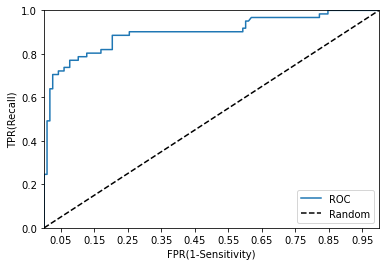

In [19]:
# ROC 곡선의 시각화
def roc_curve_plot(y_test, pred_proba_c1):
    #임계값에 따른 FPR, TPR 값을반환 받음
    fprs, tprs, thresholds  = roc_curve(y_test, pred_proba_c1)
    # ROC곡선을 그래프로 그림
    plt.plot(fprs, tprs, label='ROC')
    # 가운데 대각선 직선을 그림
    plt.plot([0,1], [0,1], 'k--', label='Random')
    
    # FPR X축의 Scale을 0.1 단위로 변경, X, Y축 명 설정 등
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel('FPR(1-Sensitivity)')
    plt.ylabel('TPR(Recall)')
    plt.legend()
    
roc_curve_plot(y_test, pred_proba[:, 1])

In [20]:
from sklearn.metrics import roc_auc_score

pred = lr_clf.predict(X_test)
roc_score = roc_auc_score(y_test, pred)
print('ROC AUC 값 : {:.4f}'.format(roc_score))

ROC AUC 값 : 0.8429


일반적으로 ROC 곡선 자체는 FPR과 TPR의 변화 값을 보는데 이용하여 분류의 성능지표로는 ROC면적에 기반한 AUC 값으로 결정

## 6. 피마 인디언 당뇨병 예측

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.preprocessing import StandardScaler, Binarizer
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

diabetes_data = pd.read_csv('diabetes.csv')
print(diabetes_data['Outcome'].value_counts())
diabetes_data.head(3)

0    500
1    268
Name: Outcome, dtype: int64


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1


In [25]:
diabetes_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [27]:
# get_clf_eval()
# 저번에 작성한 것에 ROC AUC를 추가함
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred)
    
    print('오차행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC:{4:.4f}'
          .format(accuracy, precision, recall, f1, roc_auc))
    
# get_eval_by_threshold()
def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
    # thresholds list 객체 내의 값을 차례로 iteration하면서 evaluation 수행
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)
        print(f'임곗값: {custom_threshold}')
        get_clf_eval(y_test, custom_predict)

# precision_recall_curve_plot()
def precision_recall_curve_plot(y_test, pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행, 정밀도는 점선으로 표시
    plt.figure(figsize=(8, 6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')
    
    # threshold 값 X축의 scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    
    # X, Y축 label과 legend, grid 설정
    plt.xlabel('Threshold value')
    plt.ylabel('Precision and Recall value')
    plt.legend()
    plt.grid()

In [28]:
# 피처 데이터 세트 X, 레이블 데이터 세트 y를 추출
# 맨 끝이 Outcome 칼럼으로 레이블 값임, 칼럼 위치 -1을 이용해 추출
X = diabetes_data.iloc[:, :-1]
y = diabetes_data.iloc[:, -1]

# stratify: default=None 이고, stratify 값을 target으로 지정해주면 각각의 class 비율(ratio)을 train / validation에 유지해 준다. (즉, 한 쪽에 쏠려서 분배되는 것을 방지)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=156, stratify=y)

# 로지스틱 회귀로 학습, 예측, 평가 
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:, 1]

get_clf_eval(y_test, pred, pred_proba)

오차행렬
[[88 12]
 [23 31]]
정확도: 0.7727, 정밀도: 0.7209, 재현율: 0.5741, F1: 0.6392, AUC:0.7270


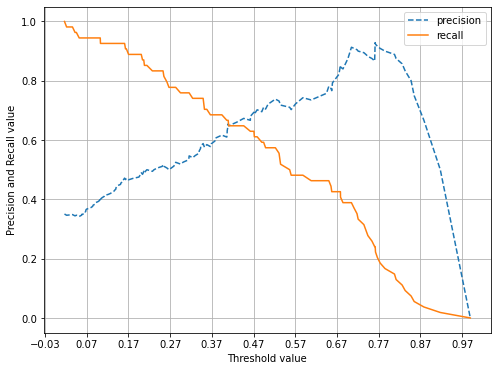

In [29]:
pred_proba_c1 = lr_clf.predict_proba(X_test)[:, 1]
precision_recall_curve_plot(y_test, pred_proba_c1)

In [30]:
diabetes_data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


(array([ 5.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.,  3.,  0.,  1.,  1.,  1.,  1.,  3.,  4.,  4.,  6.,  4.,
         7., 12.,  9., 17., 10., 15., 20., 16., 20., 17., 20., 26., 22.,
        19., 25., 25., 20., 18., 21., 18., 17., 17., 21., 25., 14., 25.,
        12., 10., 10., 16., 13., 10., 11., 12., 16.,  5.,  9.,  6., 11.,
         5., 10.,  4.,  9.,  7.,  6.,  5.,  5.,  7.,  4.,  3.,  6., 10.,
         4.,  3.,  5.,  6.,  2.,  2.,  5.,  7.,  2.]),
 array([  0.  ,   1.99,   3.98,   5.97,   7.96,   9.95,  11.94,  13.93,
         15.92,  17.91,  19.9 ,  21.89,  23.88,  25.87,  27.86,  29.85,
         31.84,  33.83,  35.82,  37.81,  39.8 ,  41.79,  43.78,  45.77,
         47.76,  49.75,  51.74,  53.73,  55.72,  57.71,  59.7 ,  61.69,
         63.68,  65.67,  67.66,  69.65,  71.64,  73.63,  75.62,  77.61,
         79.6 ,  81.59,  83.58,  85.57,  87.56,  89.55,  91.54,  93.53,
  

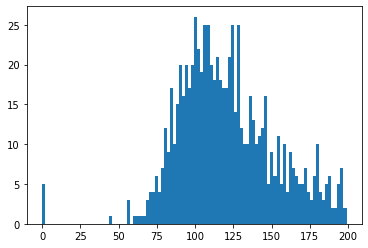

In [32]:
plt.hist(diabetes_data['Glucose'], bins=100)

In [33]:
zero_features = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
total_count = diabetes_data['Glucose'].count()
for feature in zero_features:
    zero_count = diabetes_data[diabetes_data[feature]==0][feature].count()
    print('{0} 0 건수는 {1}, 퍼센트는 {2:.2f} %'.format(feature, zero_count, 100*zero_count/total_count))
    

Glucose 0 건수는 5, 퍼센트는 0.65 %
BloodPressure 0 건수는 35, 퍼센트는 4.56 %
SkinThickness 0 건수는 227, 퍼센트는 29.56 %
Insulin 0 건수는 374, 퍼센트는 48.70 %
BMI 0 건수는 11, 퍼센트는 1.43 %


In [35]:
mean_zero_features = diabetes_data[zero_features].mean()
diabetes_data[zero_features] = diabetes_data[zero_features].replace(0, mean_zero_features)

In [36]:
X = diabetes_data.iloc[:, :-1]
y = diabetes_data.iloc[:, -1]

# StandardScaler 클래스를 이용해 피처 데이터 세트에 일괄적으로 스케일링 적용
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=156, stratify=y)

lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:, 1]

get_clf_eval(y_test, pred, pred_proba)

오차행렬
[[90 10]
 [21 33]]
정확도: 0.7987, 정밀도: 0.7674, 재현율: 0.6111, F1: 0.6804, AUC:0.7556


In [37]:
thresholds = [0.3, 0.33, 0.36, 0.39, 0.42, 0.45, 0.48, 0.50]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:, 1].reshape(-1, 1), thresholds)

임곗값: 0.3
오차행렬
[[64 36]
 [11 43]]
정확도: 0.6948, 정밀도: 0.5443, 재현율: 0.7963, F1: 0.6466, AUC:0.7181
임곗값: 0.33
오차행렬
[[70 30]
 [11 43]]
정확도: 0.7338, 정밀도: 0.5890, 재현율: 0.7963, F1: 0.6772, AUC:0.7481
임곗값: 0.36
오차행렬
[[75 25]
 [13 41]]
정확도: 0.7532, 정밀도: 0.6212, 재현율: 0.7593, F1: 0.6833, AUC:0.7546
임곗값: 0.39
오차행렬
[[77 23]
 [16 38]]
정확도: 0.7468, 정밀도: 0.6230, 재현율: 0.7037, F1: 0.6609, AUC:0.7369
임곗값: 0.42
오차행렬
[[82 18]
 [16 38]]
정확도: 0.7792, 정밀도: 0.6786, 재현율: 0.7037, F1: 0.6909, AUC:0.7619
임곗값: 0.45
오차행렬
[[84 16]
 [19 35]]
정확도: 0.7727, 정밀도: 0.6863, 재현율: 0.6481, F1: 0.6667, AUC:0.7441
임곗값: 0.48
오차행렬
[[89 11]
 [19 35]]
정확도: 0.8052, 정밀도: 0.7609, 재현율: 0.6481, F1: 0.7000, AUC:0.7691
임곗값: 0.5
오차행렬
[[90 10]
 [21 33]]
정확도: 0.7987, 정밀도: 0.7674, 재현율: 0.6111, F1: 0.6804, AUC:0.7556


In [38]:
binarizer = Binarizer(threshold=0.48)

# 위에서 구한 lr_clf의 predict_proba() 예측 확률 array에서 1에 해당하는 칼럼값을 Binarizer 변환
pred_th_048 = binarizer.fit_transform(pred_proba[:, 1].reshape(-1, 1))

get_clf_eval(y_test, pred_th_048, pred_proba[:, 1])

오차행렬
[[89 11]
 [19 35]]
정확도: 0.8052, 정밀도: 0.7609, 재현율: 0.6481, F1: 0.7000, AUC:0.7691


## 7. 정리

이진 분류의 레이블 값이 불균형하게 분포될 경우 단순히 예측 결과와 실제 결과가 일치하는 지표인 정확도 만으로는 머신러닝 모델의 예측 성능을 평가할 수 없다.